In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Analyzing events data in BigQuery

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fcloudymoma%2Fgcp-playgroud-public%2Fmaster%2FBigQuery%2Ffirebase_ga_funnels_retention.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/cloudymoma/gcp-playgroud-public/blob/master/BigQuery/firebase_ga_funnels_retention.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Bin Wu](https://github.com/bindiego) |

## Overview

The objective is to demonstrate how to use the GA/Firebase collected raw data for analytical jobs within BigQuery, including:


* Explore the data in BigQuery
  * Use parameters for SQL
  * Save results to `DataFrame` for futher analysis
  * Plot the data in python
* Use Cases
  * Build funnels based on key events
  * Calculate retentions
* Homework
  * Build more complex funnels (e.g. conversions, purchases etc.)
  * Build a 7-day retention data
  * Compare retentions among devices (e.g. iOS vs. Android, Desktop vs. Mobile)
  * Compare both funnels & retentions by apply different demographic filters
  * Use your own data, e.g. ABTests data, to select a best strategy for your funnel or retention models

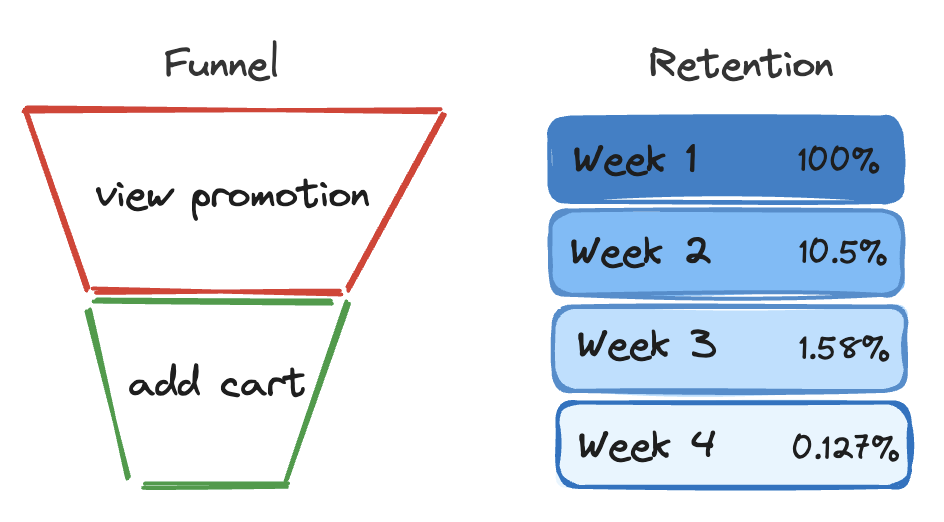

## How to open this notebook in BigQuery Studio

This notebook was written to be compatible for use within BigQuery Studio. To open this notebook, click to [Open in Colab Enterprise](https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fcloudymoma%2Fgcp-playgroud-public%2Fmaster%2FBigQuery%2Fbq_llm%2Fbqml_genai.ipynb). This will open a new window in the Cloud Console and prompt you to confirm import. Then, navigate to **BigQuery**, where you will find the notebook available in the **Explorer pane** under **Notebooks**.

## About the dataset

`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` is the public dataset in `BigQuery` everyone should be able access.

There is also another dataset named `firebase-public-project.analytics_153293282.events_*` to be more mobile game oriented you could play with.

Also, you could use [`Firebase`](https://firebase.google.com/docs/projects/bigquery-export) or [`GA`](https://support.google.com/analytics/answer/3416092?hl=en#zippy=%2Cin-this-article) integration to have your own data in `BigQuery`.

Alternatively, you can collection the data by yourself over [GCP data pipeline](https://github.com/cloudymoma/raycom). We have built the [skeleton](https://github.com/cloudymoma/raycom?tab=readme-ov-file#introduce-the-basic-mode) for you to quickly get started.

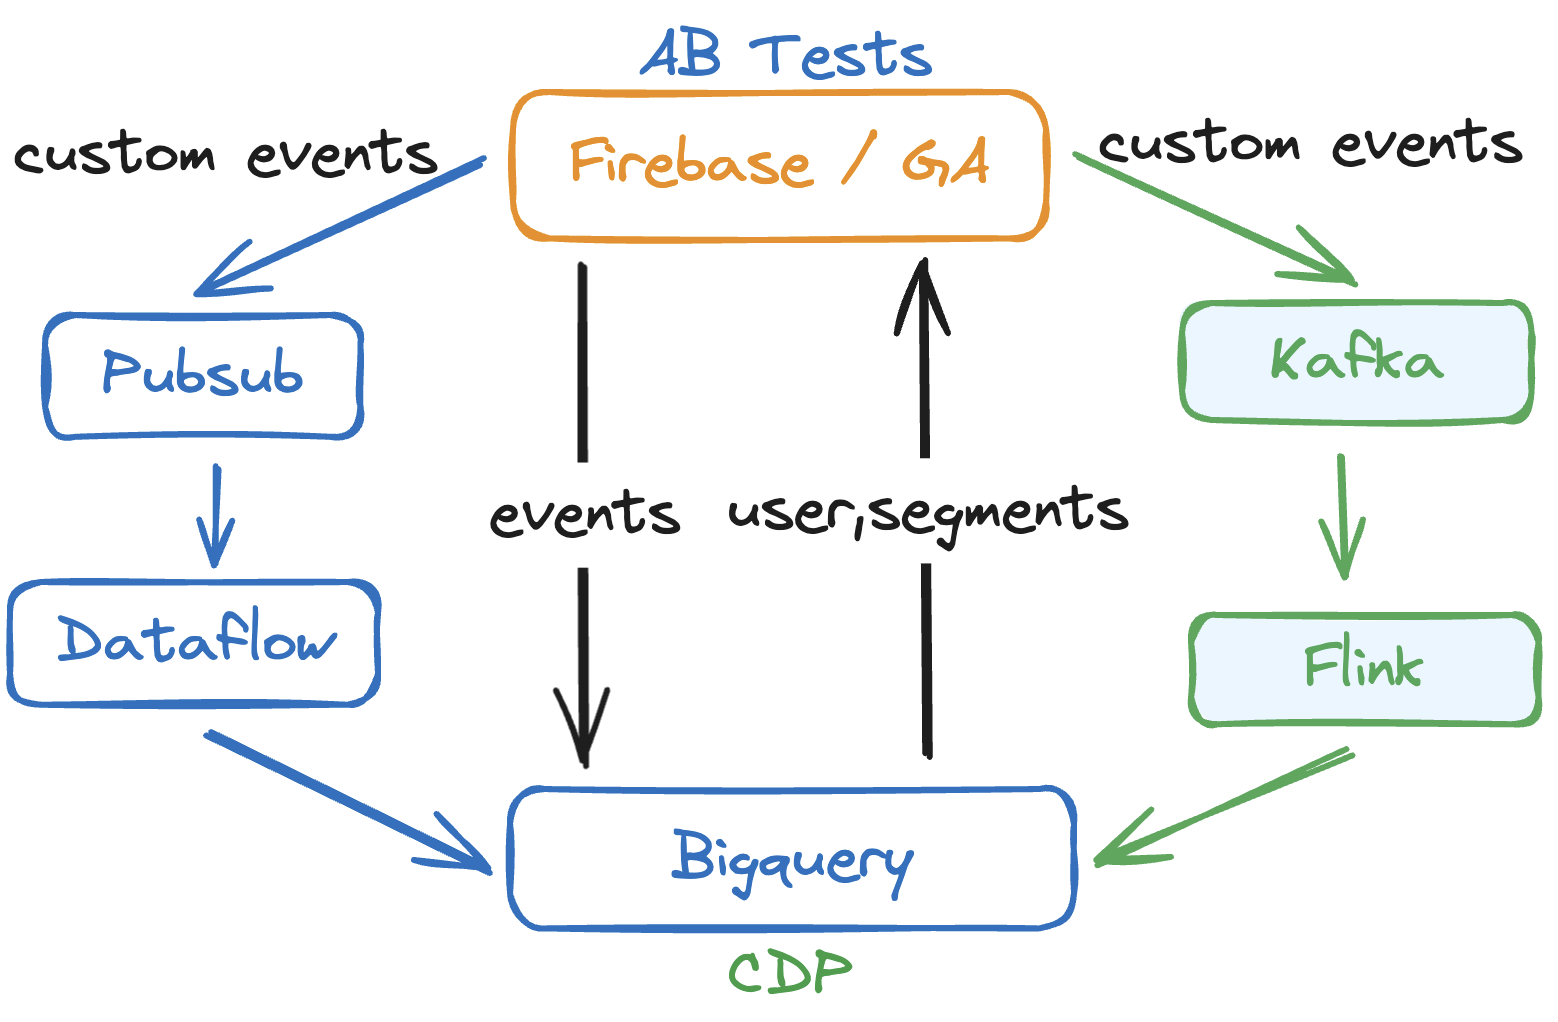

# Explore the data

Let's use the `user_engatement` event as mesurement to check daily activel users.

In [ ]:
%%bigquery dau
SELECT EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS `date`,
  countif(event_name = 'user_engagement') as num_engagements
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
group by 1
order by `date` desc;

After executing the query above, we have saved the results into [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) named `dau`. Then we could use `DataFrame` functions to explore and plot the data here in `BigQuery`.

In [ ]:
dau.head(10)

In [ ]:
dau.head(14).plot(kind="bar", x="date", y="num_engagements")

Now let's check what events are collected in the dataset.

In [ ]:
%%bigquery num_events
select distinct event_name as event_n,
 count(*) as num_events
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
group by event_n
order by num_events desc;

In [ ]:
num_events.plot(kind="barh", x="event_n", y="num_events")

# Funnel

By now, we found there are 2 interesting events `view_propotion` and `add_to_cart`. Let's see how many users actually added shopping cart after viewing the promotion.

Fristly, let's use a [window function](https://cloud.google.com/bigquery/docs/reference/standard-sql/window-function-calls) to see if there are such actions happened one after another for each user.

In [ ]:
%%bigquery --params {"event1": "view_promotion", "event2": "add_to_cart", "limit": 10}
WITH data AS (
  SELECT event_name, user_pseudo_id , event_timestamp,
    LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE (event_name = @event1 OR event_name = @event2)
  ORDER BY 2,3
) SELECT * from data
WHERE event_name = @event1 AND next_event = @event2
LIMIT @limit

Now let's sum the total numbers of each events.

In [ ]:
%%bigquery --params {"event1": "view_promotion", "event2": "add_to_cart"}
SELECT
  SUM (IF (event_name = @event1, 1, 0)) AS funnel_1_total,
  SUM (IF (event_name = @event1 AND next_event = @event2, 1, 0)) AS funnel_2_total
FROM (
  SELECT event_name, user_pseudo_id , event_timestamp,
    LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE (event_name = @event1 OR event_name = @event2)
  ORDER BY 2,3
);


What if we only count on distict users? Run the following query and compare the results.

In [ ]:
%%bigquery --params {"event1": "view_promotion", "event2": "add_to_cart"}
SELECT
  COUNT(DISTINCT funnel_1) AS funnnel_1_total,
  COUNT(DISTINCT funnel_2) AS funnel_2_total
FROM (
  SELECT
    IF (event_name = @event1, user_pseudo_id, NULL) AS funnel_1,
    IF (event_name = @event1 AND next_event = @event2, user_pseudo_id, NULL) AS funnel_2
  FROM (
    SELECT event_name, user_pseudo_id , event_timestamp,
      LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE (event_name = @event1 OR event_name = @event2)
    ORDER BY 2,3
))

Seems the nubmers changed. Now we may want to limit the second event only happened in, say `5` minutes, so we could consider the action `add_to_cart` is actually affected by the `view_promotion`. Let's see if the numbers change by running the following query.

In [ ]:
%%bigquery funnel --params {"event1": "view_promotion", "event2": "add_to_cart"}
SELECT
  COUNT(DISTINCT funnel_1) AS funnnel_1_total,
  COUNT(DISTINCT funnel_2) AS funnel_2_total
FROM (
  SELECT
    IF (event_name = @event1, user_pseudo_id, NULL) AS funnel_1,
    IF (event_name = @event1 AND next_event = @event2
      -- 5 minutes between 2 events. time_stemp is in microseconds
      AND next_timestamp - event_timestamp < 5 * 60 * 1000 * 1000,
        user_pseudo_id, NULL) AS funnel_2
  FROM (
    SELECT event_name, user_pseudo_id , event_timestamp,
      LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event,
      -- add next_timestemp
      LEAD(event_timestamp, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_timestamp
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE (event_name = @event1 OR event_name = @event2)
    ORDER BY 2,3
))

In [ ]:
funnel

Cool, it's all good so far. Let's quickly plot the data and see.

In [ ]:
funnel.plot(kind="barh").invert_yaxis()

Now have built a very basic funnel based on our events raw data.

Things to try further


*   A more complex funnel
*   Use the **`WHERE`** clause to filter the data
  * How the different promotion text could potentially affect the funnel conversions?
  * Which platform has higher conversion rate? Desktop or Mobile devicess?
  * How about performance between *`iOS`* and *`Android`*?



# Retention

Retention is another key metrics for evaluate your app / site performance. Here is a 4-week retention built based on GA/Firebase raw data. Check it out.

In [ ]:
%%bigquery --params {"retention_event": "user_engagement"}
WITH analytics_data AS (
  SELECT user_pseudo_id, event_timestamp, event_name,
    UNIX_MICROS(TIMESTAMP("2021-01-01 00:00:00", "+8:00")) AS start_day,
    3600*1000*1000*24*7 AS one_week_micros
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE _table_suffix BETWEEN '20210101' AND '20210131'
)

SELECT week_0_cohort / week_0_cohort AS week_0_pct,
 week_1_cohort / week_0_cohort AS week_1_pct,
 week_2_cohort / week_0_cohort AS week_2_pct,
 week_3_cohort / week_0_cohort AS week_3_pct
FROM (
  WITH week_3_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(3*one_week_micros) AND start_day+(4*one_week_micros)
  ),
  week_2_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(2*one_week_micros) AND start_day+(3*one_week_micros)
  ),
  week_1_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(1*one_week_micros) AND start_day+(2*one_week_micros)
  ),
  week_0_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_name = @retention_event
      AND event_timestamp BETWEEN start_day AND start_day+(1*one_week_micros)
  )
  SELECT
    (SELECT count(*)
     FROM week_0_users) AS week_0_cohort,
    (SELECT count(*)
     FROM week_1_users
     JOIN week_0_users USING (user_pseudo_id)) AS week_1_cohort,
    (SELECT count(*)
     FROM week_2_users
     JOIN week_0_users USING (user_pseudo_id)) AS week_2_cohort,
    (SELECT count(*)
     FROM week_3_users
     JOIN week_0_users USING (user_pseudo_id)) AS week_3_cohort
)

Again, now you should be able to build daily or month retentions. Also compare your strategies, UI/UX ABTests, demographic & devices data and see how is the retention performance different from one another.